In [1]:
import os
import re
import time
import sqlite3
import requests
import pandas as pd
from persiantools.jdatetime import JalaliDate
from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px

In [2]:
START_DATE = JalaliDate(1395, 1, 1)

END_DATE = JalaliDate(1410, 1, 1)

In [3]:
# Constants
DB_FILE = 'market_data.db'
EVENTS_FILE = "events.csv"

MARKET_URLS = {
    'Sandoghe-Aiar': 'https://cdn.tsetmc.com/api/ClosingPrice/GetClosingPriceDailyList/34144395039913458/0',
    'Bourse': 'https://api.tgju.org/v1/stocks/instrument/history-data/%D8%B4-%DA%A9%D9%84-%D8%A8%D9%88%D8%B1%D8%B3?order_dir=asc&market=index',
    'Fara-Bourse': 'https://api.tgju.org/v1/stocks/instrument/history-data/%D8%B4-%DA%A9%D9%84-%D9%81%D8%B1%D8%A7%D8%A8%D9%88%D8%B1%D8%B3?order_dir=asc&market=index',
    'Bourse-Khodro': 'https://api.tgju.org/v1/stocks/instrument/history-data/%D8%B4-%D8%AE%D9%88%D8%AF%D8%B1%D9%88%D8%B3%D8%A7%D8%B2%DB%8C?order_dir=asc&market=index',
    'Khesapa': 'https://api.tgju.org/v1/stocks/instrument/history-data/خساپا?order_dir=asc&market=stock&lang=fa&_=1732117631887',
    'Khodro': 'https://api.tgju.org/v1/stocks/instrument/history-data/خودرو?order_dir=asc&market=stock&lang=fa&_=1732117631887',
    'Gold': 'https://api.tgju.org/v1/market/indicator/summary-table-data/geram18?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Dollar': 'https://api.tgju.org/v1/market/indicator/summary-table-data/price_dollar_rl?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Coin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/sekee?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Nim-Coin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/nim?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Coin-Gerami': 'https://api.tgju.org/v1/market/indicator/summary-table-data/gerami?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Bitcoin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/crypto-bitcoin?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Rob-Coin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/rob?lang=fa&order_dir=asc&convert_to_ad=1&_='
}

MARKET_NAMES = {
    "Sandoghe-Aiar": "عیار-مفید",
    "Bourse": "بورس",
    # "Fara-Bourse": "فرابورس",
    # "Gold": "طلا",
    "Dollar": "دلار",
    "Coin": "سکه امامی",
    # "Nim-Coin": "نیم سکه",
    # "Coin-Gerami": "سکه گرمی",
    # "Bitcoin": "بیت کوین",
    "Rob-Coin": "ربع سکه",
    # "Bourse-Khodro": "بورس خودرو",
    # "Khesapa": "خساپا",
    "Khodro": "خودرو",
}

WEEKDAYS = {
    "Shanbeh": "شنبه",
    "Yekshanbeh": "یکشنبه",
    "Doshanbeh": "دوشنبه",
    "Seshanbeh": "سه شنبه",
    "Chaharshanbeh": "چهارشنبه",
    "Panjshanbeh": "پنجشنبه",
    "Jomeh": "جمعه",
}

COLORS = {
    "بیت کوین": "violet",
    "طلا": "gold",
    "دلار": "green",
    "سکه امامی": "blue",
    "نیم سکه": "purple",
    "ربع سکه": "cyan",
    "سکه گرمی": "pink",
    "بورس": "lime",
    "فرابورس": "salmon",
    "بورس خودرو": "gray",
    "خساپا": "red",
    "خودرو": "pink",
    "عیار-مفید": "black",
}

In [4]:
# functions

def get_season_from_jalali(month):
    month = int(month)
    if 1 <= month <= 3:
        return "بهار"  
    elif 4 <= month <= 6:
        return "تابستان"
    elif 7 <= month <= 9:
        return "پاییز"
    elif 10 <= month <= 12:
        return "زمستان"


def clean_value(value):
    if value == '-' or not value:
        return None
    
    # Extract value from "low" or "high" spans
    match = re.search(r'<span class="(?:low|high)" dir="ltr">([\d%,]+)<', value)
    if match:
        number = match.group(1).replace(',', '')
        return f'-{number}' if 'class="low"' in value else number

    # Handle "میلیون" values
    match = re.search(r'([\d.,]+)\s*<span class="currency-type">میلیون</span>', value)
    if match:
        number = float(match.group(1).replace(',', '').replace('.', '.'))
        return int(number * 1_000_000)


    match = re.search(r'<span class="label">قیمت:</span><span class="value">([\d.,]+)</span>', value, re.DOTALL)
    if match:
        return float(match.group(1).replace(',', '').replace('.', '.'))

    
    return value.strip()

# Fetch raw data from a given URL
def fetch_data(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise HTTP errors
    return response.json()

# Process data into a DataFrame based on market type
def process_market_data(market_name, url):
    raw_data = fetch_data(url)
    
    if market_name in ['Sandoghe-Aiar']:
        raw_data = raw_data.get('closingPriceDaily', [])
    else:
        raw_data = raw_data.get('data', [])
        
    if not raw_data:
        print(f"No data available for {market_name}")
        return pd.DataFrame()

    # Handle specific market structures
    if market_name in ['Bourse', 'Fara-Bourse', 'Bourse-Khodro']:
        columns = ['persian_date', 'closing', 'lowest', 'highest']
    elif market_name in ['Sandoghe-Aiar']:
        columns = ['priceChange', 'priceMin','priceMax','priceYesterday','priceFirst','last','id','insCode','dEven','hEven','pClosing','iClose','yClose','pDrCotVal','zTotTran','qTotTran5J','qTotCap']
    elif market_name in ['Khesapa', 'Khodro']:
        columns = ['persian_date', 'a', 'b', 'closing', 'c']
    else:
        columns = ['opening', 'lowest', 'highest', 'closing', 'change_amount',
                   'change_percentage', 'gregorian_date', 'persian_date']

    if market_name not in ['Sandoghe-Aiar']:
        raw_data = [[clean_value(item) for item in row] for row in raw_data]

    df = pd.DataFrame(raw_data, columns=columns[:len(raw_data[0])])

    
    # Standardize and clean DataFrame
    if 'closing' in df.columns:
        df['closing'] = df['closing'].replace({',': ''}, regex=True).astype(float)
    if 'persian_date' in df.columns:
        df['year_month'] = df['persian_date'].str[:7]
    if market_name in ['Sandoghe-Aiar']:
        df['dEven'] = df['dEven'].apply(lambda x: JalaliDate.to_jalali(int(str(x)[:4]),int(str(x)[4:6]),int(str(x)[6:8])).strftime('%Y/%m/%d'))
        df['year_month'] = df['dEven'].str[:7]
        df.rename({'dEven': 'persian_date', 'pClosing': 'closing'}, axis=1, inplace=True)
    
    df['market_type'] = market_name
    return df[['closing', 'persian_date', 'year_month', 'market_type']].fillna('')

# Update the database with new data
def update_database(df, conn, table_name='market_data'):
    try:
        existing_data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    except Exception:
        existing_data = pd.DataFrame()

    if not existing_data.empty:
        new_data = df.merge(existing_data, how='outer', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
    else:
        new_data = df

    if not new_data.empty:
        new_data.to_sql(table_name, conn, if_exists='append', index=False)
        print(f"Inserted {len(new_data)} new records.")
    else:
        print("No new records to insert.")


def convert_persian_to_jalali(persian_date):
    year, month, day = map(int, persian_date.split('/'))  # Split and convert to integers
    return JalaliDate(year, month, day)

def convert_persian_to_weekday(persian_date):
    return date.strftime('%A')


# Set custom height for the output cell
def set_custom_output_height(height=800):
    display(HTML(f'<style>.output {{ height: {height}px; overflow-y: scroll; }}</style>'))

# Generate hover text, marker colors, and sizes based on event matches
def generate_event_annotations(monthly_data, events_df):
    hover_texts, marker_colors, marker_sizes = [], [], []
    for date in monthly_data['year_month']:
        matching_events = events_df[events_df['Date'] == date]
        if not matching_events.empty:
            # Combine all matching event names into one hover text
            event_names = "<br>".join(matching_events['Event'].tolist())
            hover_texts.append(f"<b>{event_names}</b>")
            marker_colors.append('yellow')  # Highlight event points
            marker_sizes.append(2)  # Larger marker size for events
        else:
            hover_texts.append("")  # No event for this date
            marker_colors.append('rgba(0,0,0,0)')  # Transparent for non-events
            marker_sizes.append(0)  # Invisible marker size
    return hover_texts, marker_colors, marker_sizes

# Create a reusable function to generate the chart
def create_market_chart(monthly_data_dict, events_df, y_field, title, yaxis_title, colors, height=800):
    fig = go.Figure()

    # Iterate over each market and add traces
    for name, monthly_data in monthly_data_dict.items():
        hover_texts, marker_colors, marker_sizes = generate_event_annotations(monthly_data, events_df)

        fig.add_trace(go.Scatter(
            x=monthly_data['year_month'],
            y=monthly_data[y_field],
            mode='lines+markers',
            name=name,
            hoverinfo="text",  # Only show custom hover text
            text=hover_texts,  # Custom hover text
            marker=dict(
                color=marker_colors,  # Assign colors based on event occurrence
                size=marker_sizes,  # Show marker size only for events
                line=dict(width=1, color="darkred")  # Optional: outline markers
            ),
            line=dict(color=colors.get(name, "black"), width=2)  # Default to black if not in colors
        ))

    # Chart settings
    fig.update_layout(
        title=title,
        xaxis_title="Date (Month to Month)",
        yaxis_title=yaxis_title,
        xaxis=dict(
            type="category",
            tickangle=-90
        ),
        template='plotly_white',
        showlegend=True,
        height=height
    )

    fig.show()

    return fig


def plot_stacked_bar_chart(df, x_col, y_col, color_col, title, labels=None, height=800):
    """
    Plots a stacked bar chart using Plotly Express.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - x_col (str): Column name for the x-axis.
    - y_col (str): Column name for the y-axis.
    - color_col (str): Column name for the color grouping.
    - title (str): The title of the chart.
    - labels (dict, optional): Custom labels for axis and legend.
    - height (int, optional): The height of the chart.

    Returns:
    - fig (plotly.graph_objects.Figure): The Plotly figure object.
    """
    # Create the stacked bar chart
    fig = px.bar(
        df,
        x=x_col,
        y=y_col,
        color=color_col,
        title=title,
        labels=labels or {},
        barmode="stack",  # Stacked bars
        text=y_col,
        height=height,
    )

    # Customize layout
    fig.update_layout(
        xaxis=dict(
            title=x_col.capitalize(),
            categoryorder="array",
            categoryarray=sorted(df[x_col].unique()),
            tickangle=0
        ),
        yaxis=dict(title=y_col.capitalize()),
        legend_title=color_col.capitalize(),
        margin=dict(l=40, r=40, t=40, b=40)
    )

    # Add interactivity to tooltips
    fig.update_traces(texttemplate='%{text:.2f}', textposition='inside')

    fig.show()
    
    return fig


In [5]:
# conn = sqlite3.connect(DB_FILE)

# # Main Workflow
# all_data_frames = []

# for market_name, url in MARKET_URLS.items():
#     market_df = process_market_data(market_name, url)
#     all_data_frames.append(market_df)

# # Combine all market data into a single DataFrame
# final_df = pd.concat(all_data_frames, ignore_index=True)

# # Update database
# update_database(final_df, conn)

# # Commit and close connection
# conn.commit()

# print("Database update completed.")

In [6]:
conn = sqlite3.connect(DB_FILE)

df = pd.read_sql_query("SELECT * FROM market_data WHERE market_type IN ({})".format(", ".join(f"'{key}'" for key in MARKET_NAMES.keys())), conn)

events_df = pd.read_csv(EVENTS_FILE)

conn.close()

In [7]:
df['persian_date_jalali'] = df['persian_date'].apply(convert_persian_to_jalali)
df['week_day'] = df['persian_date_jalali'].apply(lambda x: x.strftime('%A'))
df['year'] = df['persian_date_jalali'].apply(lambda x: x.strftime('%Y'))
df.loc[:, 'year'] = df['year'].astype(int)
df.loc[:, 'two_year_period'] = (df['year'] // 2) * 2
df.loc[:, 'two_year_period'] = df['two_year_period'].astype(str) + '-' + (df['two_year_period'] + 1).astype(str)
df.loc[:, 'three_year_period'] = (df['year'] // 3) * 3
df.loc[:, 'three_year_period'] = df['three_year_period'].astype(str) + '-' + (df['three_year_period'] + 1).astype(str) + '-' + (df['three_year_period'] + 2).astype(str)
df.loc[:, 'four_year_period'] = (df['year'] // 4) * 4
df.loc[:, 'four_year_period'] = df['four_year_period'].astype(str) + '-' + (df['four_year_period'] + 1).astype(str) + '-' + (df['four_year_period'] + 2).astype(str) + '-' + (df['four_year_period'] + 3).astype(str)
df['month'] = df['year_month'].str[-2:]
df['season'] = df['month'].apply(lambda x : get_season_from_jalali(x))

all_data_df = df

df = df[(df['persian_date_jalali'] >= START_DATE) & (df['persian_date_jalali'] < END_DATE)]

In [8]:
# بررسی دیتا بر اساس موجودیت

# # Prepare the data
# result = df[df['market_type'] == 'Bitcoin'].groupby('year_month')['closing'].count().reset_index()

# # Plot
# fig = px.bar(
#     result,
#     x='year_month',
#     y='closing',
#     title='Count of Closing by Year-Month (Bourse)',
#     labels={'year_month': 'Year-Month', 'closing': 'Count'},
#     text='closing'  # Add the count value on the bars
# )

# # Customize Layout
# fig.update_traces(marker_color='skyblue', textposition='outside')
# fig.update_layout(
#     xaxis_title='Year-Month',
#     yaxis_title='Count',
#     xaxis_tickangle=90,
#     template='plotly_white',
#     title_font_size=16,
#     height=500
# )

# fig.show()


In [9]:
# بررسی دیتا بر اساس موجودیت

# new_df = df[df['market_type'] != 'Bitcoin']

# # Prepare the data
# heatmap_data = new_df.groupby(['market_type', 'year_month'])['closing'].count().reset_index()

# # Pivot the data for the heatmap (rows: market_type, columns: year_month)
# heatmap_pivot = heatmap_data.pivot(index='market_type', columns='year_month', values='closing').fillna(0)

# # Plot
# fig = px.imshow(
#     heatmap_pivot,
#     labels=dict(x="Year-Month", y="Market Type", color="Count"),
#     title="Density of Closing Count by Year-Month and Market Type",
#     color_continuous_scale="Viridis",
#     aspect="auto"  # Automatically adjusts aspect ratio
# )

# # Customize Layout
# fig.update_layout(
#     xaxis_title="Year-Month",
#     yaxis_title="Market Type",
#     title_font_size=16,
#     height=800,
#     xaxis=dict(tickangle=90)  # Rotate x-axis labels
# )

# fig.show()


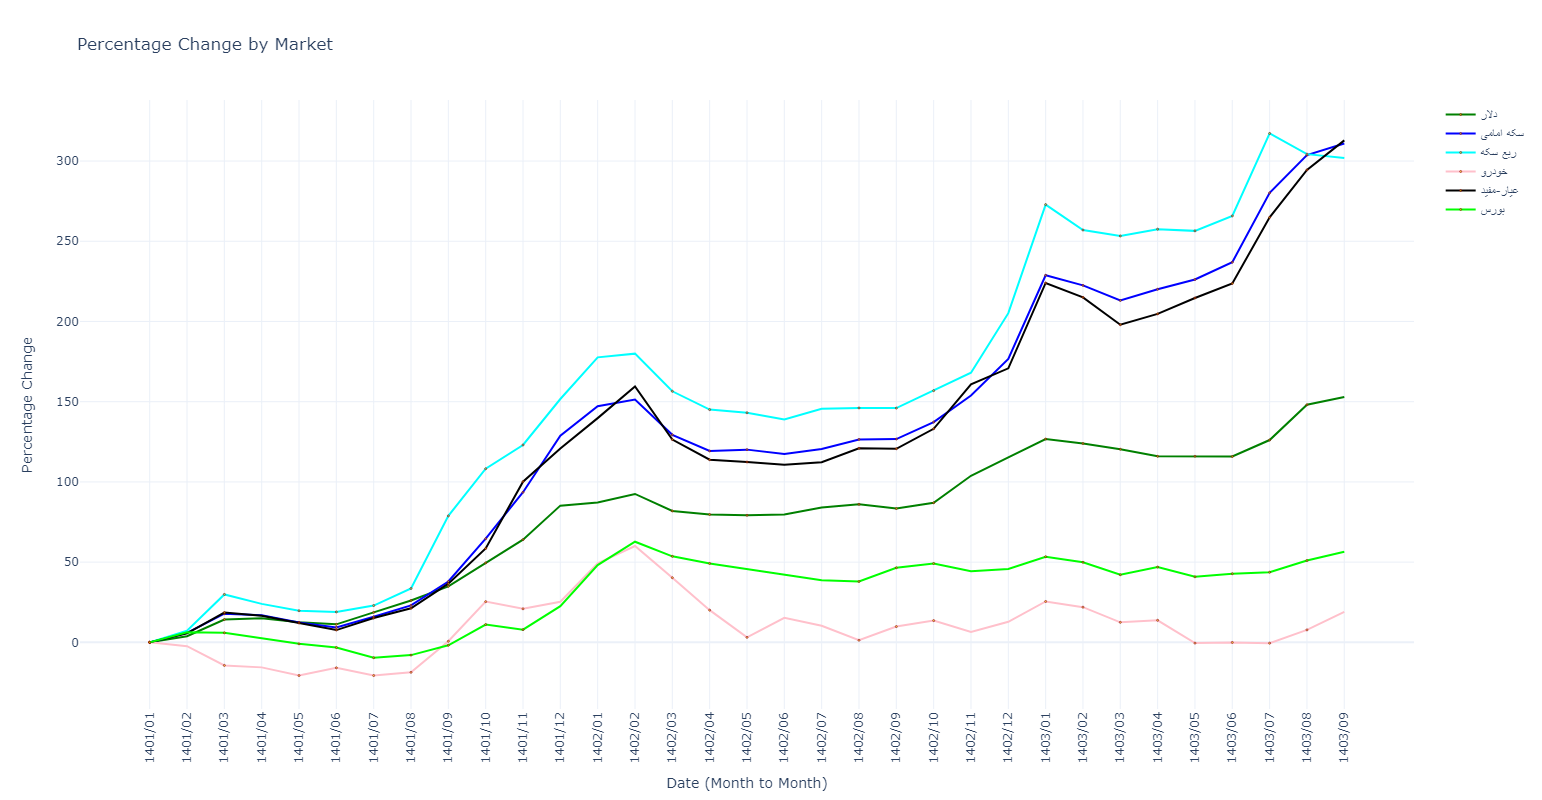

In [26]:
monthly_data_dict = {}

for market_type in df['market_type'].unique():
    market_data = df[df['market_type'] == market_type]

    market_data = market_data[market_data['year'] >= 1401]
    
    # Calculate monthly average price and percentage change
    grouped = market_data.groupby('year_month').agg(
        avg_closing_price=('closing', 'mean')
    )
    grouped['price_change_in_percentage'] = (grouped['avg_closing_price'] / grouped['avg_closing_price'].iloc[0] - 1) * 100
    grouped['price_change'] = grouped['avg_closing_price'] / grouped['avg_closing_price'].iloc[0]

    # Add data to dictionary
    monthly_data_dict[MARKET_NAMES.get(str(market_type), 'Unknown')] = {
        'year_month': grouped.index.tolist(),
        'price_change_in_percentage': grouped['price_change_in_percentage'].tolist(),
        'price_change': grouped['price_change'].tolist()
    }

monthly_data_dict = {
    k: v for k, v in sorted(monthly_data_dict.items(), key=lambda item: item[1]['year_month'])
}

# Set output cell height
set_custom_output_height(height=800)

# Generate charts
fig = create_market_chart(
    monthly_data_dict,
    events_df,
    y_field='price_change_in_percentage',
    title="Percentage Change by Market",
    yaxis_title="Percentage Change",
    colors=COLORS
)

fig.write_html('interactive_chart.html')

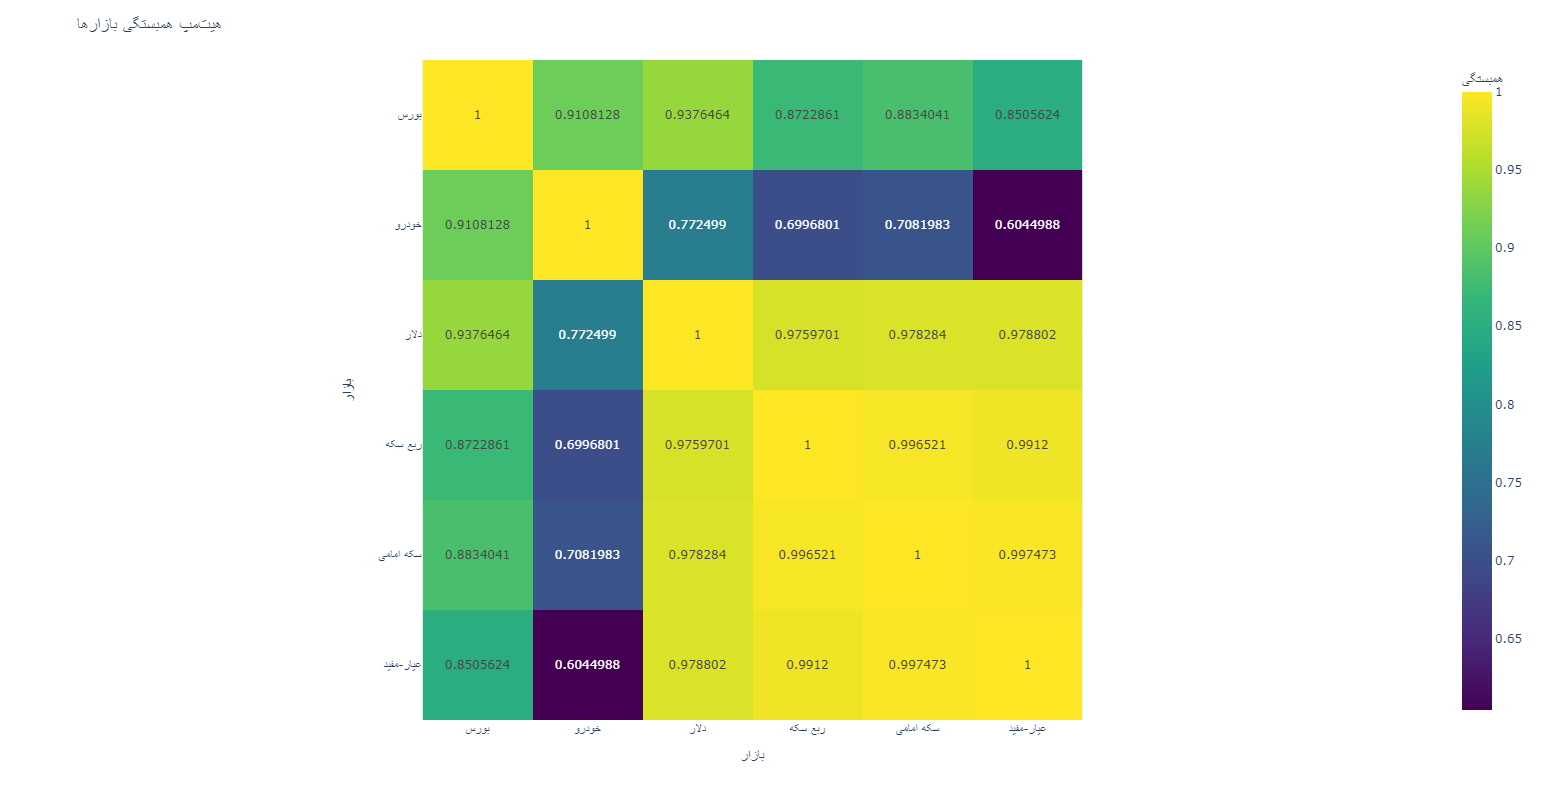

In [11]:
set_custom_output_height(height=800)

pivot_df = df.copy()

pivot_df = pivot_df[pivot_df['market_type'] != 'Bourse-Khodro']
# pivot_df = pivot_df[pivot_df['market_type'] != 'Bitcoin']
pivot_df['market_type'] = pivot_df['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))

pivot_df = pivot_df.pivot(index='persian_date', columns='market_type', values='closing')

correlation_matrix = pivot_df.corr()

fig = px.imshow(correlation_matrix,
                text_auto=True,
                labels=dict(x="بازار", y="بازار", color="همبستگی"),
                x=correlation_matrix.columns,
                y=correlation_matrix.index,
                color_continuous_scale="Viridis")

fig.update_layout(title="هیت‌مپ همبستگی بازارها",
                  height=800,
                  xaxis_title="بازار",
                  yaxis_title="بازار")

fig.show()

In [12]:
yearly_growth_rate = df

# yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['market_type'] == 'Coin-Gerami']
# yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['market_type'] != 'Sandoghe-Aiar']
# yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['market_type'] != 'Coin']
# yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['market_type'] != 'Nim-Coin']
# yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['market_type'] != 'Bitcoin']
# yearly_growth_rate = yearly_growth_rate[(yearly_growth_rate['market_type'] == 'Coin-Gerami') | (yearly_growth_rate['market_type'] == 'Dollar')]
yearly_growth_rate = (yearly_growth_rate.groupby(['market_type','year']).agg(growth_rate= ('closing', 'mean')).groupby(level='market_type')['growth_rate'].pct_change() * 100).reset_index()
yearly_growth_rate = yearly_growth_rate.sort_values(['year', 'growth_rate'], ascending=[True, False]).groupby('year', group_keys=False).head(5)


yearly_growth_rate['market_type'] = yearly_growth_rate['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))
# yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['year'] != 1399]
# yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['year'] != 1397]
yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['year'] != 1395]

set_custom_output_height(height=800)

fig = plot_stacked_bar_chart(
    df=yearly_growth_rate,
    x_col="year",
    y_col="growth_rate",
    color_col="market_type",
    title="Top 5 Markets by Growth Rate for Each Year (Stacked)",
    labels={"growth_rate": "Growth Rate (%)", "year": "Year"}
)

In [13]:
yearly_growth_rate = df
yearly_growth_rate = (yearly_growth_rate.groupby(['market_type','year']).agg(growth_rate= ('closing', 'mean')).groupby(level='market_type')['growth_rate'].pct_change() * 100).reset_index()
yearly_growth_rate = yearly_growth_rate.sort_values(['year', 'growth_rate'], ascending=[True, False]).groupby('year', group_keys=False).head(5000)
yearly_growth_rate["rank"] = yearly_growth_rate.groupby("year")["growth_rate"].rank(ascending=False, method="dense")
yearly_growth_rate = yearly_growth_rate[yearly_growth_rate['year'] != 1395]
yearly_growth_rate['market_type'] = yearly_growth_rate['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))
heatmap_data = yearly_growth_rate.pivot(index="market_type", columns="year", values="rank")
growth_rate_data = yearly_growth_rate.pivot(index="market_type", columns="year", values="growth_rate")



# Create the heatmap
fig = px.imshow(
    heatmap_data,
    labels={"x": "Year", "y": "Market Type", "color": "Rank"},
    title="Market Rankings by Year",
    text_auto=True,
)

# Add hover data using hovertemplate
fig.update_traces(
    hovertemplate=(
        "Market Type: %{y}<br>"
        "Year: %{x}<br>"
        "Rank: %{z}<br>"
        "Growth Rate: %{customdata}"
    ),
    customdata=growth_rate_data.values  # Add growth_rate as hover data
)

# Reverse Y-axis and adjust layout
fig.update_layout(
    yaxis=dict(autorange="reversed"),
    height=800
)

# Show the figure
fig.show()


In [14]:
mean_yearly_rank_df = yearly_growth_rate[yearly_growth_rate['year'] != 1403].groupby('market_type').agg(mean_rank= ('rank','mean')).sort_values('mean_rank')
current_yearly_rank_df = yearly_growth_rate[yearly_growth_rate['year'] == 1403]
current_yearly_rank_df = current_yearly_rank_df.rename(columns={"rank": "current_rank"})
current_yearly_rank_df.merge(mean_yearly_rank_df, how='inner', on='market_type').sort_values('mean_rank')[['market_type', 'mean_rank', 'current_rank']]

,market_type,mean_rank,current_rank
0,سکه امامی,2.428571,1.0
1,ربع سکه,2.428571,2.0
2,عیار-مفید,3.600000,3.0
3,دلار,3.857143,4.0
4,بورس,3.857143,5.0
5,خودرو,4.142857,6.0


In [15]:
seasonal_data = (df.groupby(['market_type','year','season']).agg(mean_closing= ('closing', 'mean'))).reset_index()

seasonal_data = pd.merge(seasonal_data, seasonal_data.groupby(['market_type', 'year'])['mean_closing'].sum().reset_index(), on=['year', 'market_type'])

seasonal_data['influence_percentage'] = ((seasonal_data['mean_closing_x'] / seasonal_data['mean_closing_y']) * 100).astype(int)

seasonal_data['market_type'] = seasonal_data['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))


# Plotting: Add season to tooltip
fig = px.bar(
    seasonal_data,
    x="year",
    y="influence_percentage",
    color="market_type",  # Keep market_type as stack
    title="Influence of Seasons by Year and Market",
    labels={
        "influence_percentage": "Influence (%)",
        "year": "Year",
        "market_type": "Market Type"
    },
    text="influence_percentage",  # Display influence percentage on bars
    hover_data=["season"]  # Include season name in tooltip
)

# Customize layout
fig.update_layout(
    xaxis=dict(title="Year", categoryorder="array", tickangle=0),
    yaxis=dict(title="Influence (%)"),
    legend_title="Market Type",
    height=800,
    margin=dict(l=40, r=40, t=40, b=40)
)

# Show the chart
fig.show()


In [16]:
monthly_data = (df.groupby(['market_type','year','month']).agg(mean_closing= ('closing', 'mean'))).reset_index()

monthly_data = pd.merge(monthly_data, monthly_data.groupby(['market_type', 'year'])['mean_closing'].sum().reset_index(), on=['year', 'market_type'])

monthly_data['influence_percentage'] = ((monthly_data['mean_closing_x'] / monthly_data['mean_closing_y']) * 100).astype(int)

monthly_data = monthly_data[monthly_data['market_type'] == 'Sandoghe-Aiar']

monthly_data['market_type'] = monthly_data['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))


# Plotting: Add season to tooltip
fig = px.bar(
    monthly_data,
    x="year",
    y="influence_percentage",
    color="month",  # Keep market_type as stack
    title="Influence of Monthes by Year and Market",
    labels={
        "influence_percentage": "Influence (%)",
        "year": "Year",
        "market_type": "Market Type"
    },
    text="influence_percentage",  # Display influence percentage on bars
    hover_data=["month"]  # Include month name in tooltip
)

# Customize layout
fig.update_layout(
    xaxis=dict(title="Year", categoryorder="array", tickangle=0),
    yaxis=dict(title="Influence (%)"),
    legend_title="Market Type",
    height=800,
    margin=dict(l=40, r=40, t=40, b=40)
)

# Show the chart
fig.show()


In [17]:
two_year_df = (df.groupby(['two_year_period', 'market_type']).agg(growth_rate= ('closing', 'mean')).groupby(level='market_type')['growth_rate'].pct_change() * 100).reset_index()
two_year_df = two_year_df.sort_values(['two_year_period', 'growth_rate'], ascending=[True, False]).groupby('two_year_period', group_keys=False).head(5)
two_year_df['market_type'] = two_year_df['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))
two_year_df = two_year_df[two_year_df['two_year_period'] != '1394-1395']

set_custom_output_height(height=800)

fig = plot_stacked_bar_chart(
    df=two_year_df,
    x_col="two_year_period",
    y_col="growth_rate",
    color_col="market_type",
    title="Top 5 Markets by Growth Rate for Each Two Year Period (Stacked)",
    labels={"growth_rate": "Growth Rate (%)", "year": "Year"}
)

In [18]:
three_year_df = (df.groupby(['three_year_period', 'market_type']).agg(growth_rate= ('closing', 'mean')).groupby(level='market_type')['growth_rate'].pct_change() * 100).reset_index()
three_year_df = three_year_df.sort_values(['three_year_period', 'growth_rate'], ascending=[True, False]).groupby('three_year_period', group_keys=False).head(5)
three_year_df['market_type'] = three_year_df['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))
three_year_df = three_year_df[three_year_df['three_year_period'] != '1395-1396-1397']

set_custom_output_height(height=800)

fig = plot_stacked_bar_chart(
    df=three_year_df,
    x_col="three_year_period",
    y_col="growth_rate",
    color_col="market_type",
    title="Top 5 Markets by Growth Rate for Each Three Year Period (Stacked)",
    labels={"growth_rate": "Growth Rate (%)", "year": "Year"}
)

In [19]:
four_year_df = (df.groupby(['four_year_period', 'market_type']).agg(growth_rate= ('closing', 'mean')).groupby(level='market_type')['growth_rate'].pct_change() * 100).reset_index()
four_year_df = four_year_df.sort_values(['four_year_period', 'growth_rate'], ascending=[True, False]).groupby('four_year_period', group_keys=False).head(5)
four_year_df['market_type'] = four_year_df['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))
four_year_df = four_year_df[four_year_df['four_year_period'] != '1392-1393-1394-1395']


set_custom_output_height(height=800)

fig = plot_stacked_bar_chart(
    df=four_year_df,
    x_col="four_year_period",
    y_col="growth_rate",
    color_col="market_type",
    title="Top 5 Markets by Growth Rate for Each Three Year Period (Stacked)",
    labels={"growth_rate": "Growth Rate (%)", "year": "Year"}
)

In [20]:
# # سرمایه گذاری بر اساس روز های هفته

# # Function to get the start date of the Persian year for a given Persian date
# def get_persian_year_start(persian_date):
#     year, _, _ = map(int, persian_date.split('/'))
#     return JalaliDate(year, 1, 1)  # 1st day of the Persian year

# # Function to calculate the number of weeks since the beginning of the Persian year
# def get_jalali_week_number(persian_date):
#     # Convert the Persian date to JalaliDate object
#     year, month, day = map(int, persian_date.split('/'))
#     jalali_date = JalaliDate(year, month, day)

#     # Get the start of the Persian year for this date
#     persian_year_start = get_persian_year_start(persian_date)
    
#     # Calculate the number of days between the given date and the start of the year
#     days_diff = (jalali_date - persian_year_start).days

#     # Calculate the week number (days divided by 7)
#     return (days_diff // 7) + 1  # Adding 1 to start the count from 1

# # Function to calculate sequential week numbers, handling week changes
# def calculate_sequential_week_numbers(df, date_column):
#     df = df.copy()  # Avoid modifying the original DataFrame

#     # Calculate week numbers for each date
#     df['jalali_week'] = df[date_column].apply(get_jalali_week_number)

#     # Sequential week numbering
#     sequential_week = 0
#     last_week = None

#     week_numbers = []
#     for week in df['jalali_week']:
#         if week != last_week:
#             sequential_week += 1
#         week_numbers.append(sequential_week)
#         last_week = week

#     df['week_num'] = week_numbers
#     return df
    
# df = calculate_sequential_week_numbers(df, 'persian_date')
# df['weekly_rank'] = df.groupby('week_num')['closing'].rank(ascending=False, method='dense').astype(int)
# weekly_rankings = df.groupby(['week_day', 'market_type'])['weekly_rank'].sum().reset_index().sort_values(by='weekly_rank')

# weekly_rankings_day = df.groupby(['week_day', 'market_type']).agg(
#     total_weekly_rank=('weekly_rank', 'sum')
# ).reset_index()

# filtered_data = weekly_rankings_day[weekly_rankings_day['week_day'] != 'Jomeh']

# filtered_data['market_type'] = filtered_data['market_type'].apply(lambda x: MARKET_NAMES.get(str(x), 'Unknown'))
# filtered_data['week_day'] = filtered_data['week_day'].apply(lambda x: WEEKDAYS.get(str(x), 'Unknown'))


# pivot_data = filtered_data.pivot(
#     index='market_type', 
#     columns='week_day', 
#     values='total_weekly_rank'
# ).fillna(0)

# fig = go.Figure()

# for market in pivot_data.columns:
#     fig.add_trace(go.Bar(
#         x=pivot_data.index,
#         y=pivot_data[market], 
#         name=market
#     ))

# fig.update_layout(
#     barmode='group',
#     title='Total Weekly Rank by Market and Weekday (Excluding Friday)',
#     xaxis_title='Market Type',
#     yaxis_title='Total Weekly Rank',
#     legend_title='Weekday',
#     template='plotly_white',
#     height=500
# )

# fig.show()

In [21]:
# # Function to get the start date of the Persian year for a given Persian date
# def get_persian_year_start(persian_date):
#     year, _, _ = map(int, persian_date.split('/'))
#     return JalaliDate(year, 1, 1)  # 1st day of the Persian year

# # Function to calculate the number of weeks since the beginning of the Persian year
# def get_jalali_week_number(persian_date):
#     # Convert the Persian date to JalaliDate object
#     year, month, day = map(int, persian_date.split('/'))
#     jalali_date = JalaliDate(year, month, day)

#     # Get the start of the Persian year for this date
#     persian_year_start = get_persian_year_start(persian_date)
    
#     # Calculate the number of days between the given date and the start of the year
#     days_diff = (jalali_date - persian_year_start).days

#     # Calculate the week number (days divided by 7)
#     return (days_diff // 7) + 1  # Adding 1 to start the count from 1

# def calculate_sequential_month_numbers(df):
#     df = df.copy()  # Avoid modifying the original DataFrame

#     df['jalali_month'] = df['year_month'].apply(get_jalali_month_number)

#     sequential_month = 0
#     last_month = None

#     month_numbers = []
#     for week in df['jalali_week']:
#         if week != last_week:
#             sequential_week += 1
#         week_numbers.append(sequential_week)
#         last_week = week

#     df['week_num'] = week_numbers
#     return df

# df = calculate_sequential_week_numbers(df, 'persian_date')
# df['weekly_rank'] = df.groupby('week_num')['closing'].rank(ascending=False, method='dense').astype(int)
# weekly_rankings = df.groupby(['week_day', 'market_type'])['weekly_rank'].sum().reset_index().sort_values(by='weekly_rank')

# weekly_rankings_day = df.groupby(['week_day', 'market_type']).agg(
#     total_weekly_rank=('weekly_rank', 'sum')
# ).reset_index()

# filtered_data = weekly_rankings_day[weekly_rankings_day['week_day'] != 'Jomeh']

# pivot_data = filtered_data.pivot(
#     index='market_type', 
#     columns='week_day', 
#     values='total_weekly_rank'
# ).fillna(0)

# fig = go.Figure()

# for market in pivot_data.columns:
#     fig.add_trace(go.Bar(
#         x=pivot_data.index,
#         y=pivot_data[market], 
#         name=market
#     ))

# fig.update_layout(
#     barmode='group',
#     title='Total Weekly Rank by Market and Weekday (Excluding Friday)',
#     xaxis_title='Market Type',
#     yaxis_title='Total Weekly Rank',
#     legend_title='Weekday',
#     template='plotly_white',
#     height=500
# )

# # fig.show()

# بورس

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

monthly_avg = df[df['market_type'] == 'Bourse'].groupby(['year','month']).agg(avg_closing_price=('closing', 'mean')).reset_index()

# Create a subplot with 2 columns
unique_years = monthly_avg['year'].unique()
num_years = len(unique_years)

# Define the number of columns for the subplot (2 columns)
columns = 2
rows = (num_years + 1) // 2  # This will ensure that if there's an odd number of charts, the last row has only one chart

# Create subplots
fig = make_subplots(
    rows=rows, cols=columns,
    subplot_titles=[f"Average Monthly Closing Price for {year}" for year in unique_years]
)

# Loop through each year and create a line chart
for idx, year in enumerate(unique_years):
    yearly_data = monthly_avg[monthly_avg['year'] == year]
    
    # Calculate the row and column for the current chart
    row = idx // columns + 1
    col = idx % columns + 1
    
    # Add a line chart to the subplot
    fig.add_trace(
        go.Scatter(
            x=yearly_data['month'],
            y=yearly_data['avg_closing_price'],
            mode='lines+markers',
            name=f"Year {year}",
            line=dict(width=2),
            marker=dict(size=6)
        ),
        row=row, col=col
    )

# Update layout to make sure it looks good
fig.update_layout(
    template="plotly_white",
    title="Average Monthly Closing Prices",
    showlegend=False,
    height=300 * rows,  # Adjust height based on the number of rows
    xaxis_title="Month",
    yaxis_title="Average Closing Price",
)

# Display the plot
fig.show()


# ربع سکه

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

monthly_avg = df[df['market_type'] == 'Rob-Coin'].groupby(['year','month']).agg(avg_closing_price=('closing', 'mean')).reset_index()

# Create a subplot with 2 columns
unique_years = monthly_avg['year'].unique()
num_years = len(unique_years)

# Define the number of columns for the subplot (2 columns)
columns = 2
rows = (num_years + 1) // 2  # This will ensure that if there's an odd number of charts, the last row has only one chart

# Create subplots
fig = make_subplots(
    rows=rows, cols=columns,
    subplot_titles=[f"Average Monthly Closing Price for {year}" for year in unique_years]
)

# Loop through each year and create a line chart
for idx, year in enumerate(unique_years):
    yearly_data = monthly_avg[monthly_avg['year'] == year]
    
    # Calculate the row and column for the current chart
    row = idx // columns + 1
    col = idx % columns + 1
    
    # Add a line chart to the subplot
    fig.add_trace(
        go.Scatter(
            x=yearly_data['month'],
            y=yearly_data['avg_closing_price'],
            mode='lines+markers',
            name=f"Year {year}",
            line=dict(width=2),
            marker=dict(size=6)
        ),
        row=row, col=col
    )

# Update layout to make sure it looks good
fig.update_layout(
    template="plotly_white",
    title="Average Monthly Closing Prices",
    showlegend=False,
    height=300 * rows,  # Adjust height based on the number of rows
    xaxis_title="Month",
    yaxis_title="Average Closing Price",
)

# Display the plot
fig.show()


# صندوق عیار طلا

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

monthly_avg = df[df['market_type'] == 'Sandoghe-Aiar'].groupby(['year','month']).agg(avg_closing_price=('closing', 'mean')).reset_index()

# Create a subplot with 2 columns
unique_years = monthly_avg['year'].unique()
num_years = len(unique_years)

# Define the number of columns for the subplot (2 columns)
columns = 2
rows = (num_years + 1) // 2  # This will ensure that if there's an odd number of charts, the last row has only one chart

# Create subplots
fig = make_subplots(
    rows=rows, cols=columns,
    subplot_titles=[f"Average Monthly Closing Price for {year}" for year in unique_years]
)

# Loop through each year and create a line chart
for idx, year in enumerate(unique_years):
    yearly_data = monthly_avg[monthly_avg['year'] == year]
    
    # Calculate the row and column for the current chart
    row = idx // columns + 1
    col = idx % columns + 1
    
    # Add a line chart to the subplot
    fig.add_trace(
        go.Scatter(
            x=yearly_data['month'],
            y=yearly_data['avg_closing_price'],
            mode='lines+markers',
            name=f"Year {year}",
            line=dict(width=2),
            marker=dict(size=6)
        ),
        row=row, col=col
    )

# Update layout to make sure it looks good
fig.update_layout(
    template="plotly_white",
    title="Average Monthly Closing Prices",
    showlegend=False,
    height=300 * rows,  # Adjust height based on the number of rows
    xaxis_title="Month",
    yaxis_title="Average Closing Price",
)

# Display the plot
fig.show()


# مقایسه ی همه ی بازار ها

In [25]:
comparison_df = ((df[df['month'].isin(['08', '12'])]
    .groupby(['market_type', 'year', 'month'])
    .agg(avg_closing_price=('closing', 'mean'))
    .groupby('year')['avg_closing_price']
    .pct_change() * 100)
    .reset_index()
)

comparison_df['avg_closing_price'] = comparison_df['avg_closing_price'].fillna(0).astype(int)

comparison_df[(comparison_df['month'] == '12')].pivot(index='year', columns='market_type', values='avg_closing_price')

market_type,Bourse,Coin,Dollar,Khodro,Rob-Coin,Sandoghe-Aiar
year,,,,,,
1395,-2.0,7.0,3.0,-15.0,26.0,NaN
1396,10.0,16.0,15.0,6.0,26.0,NaN
1397,-7.0,8.0,6.0,3.0,39.0,5.0
1398,69.0,47.0,33.0,50.0,37.0,55.0
1399,-4.0,-17.0,-9.0,-22.0,-16.0,-14.0
1400,-6.0,0.0,-7.0,14.0,7.0,-1.0
1401,33.0,85.0,46.0,54.0,88.0,82.0
1402,5.0,22.0,15.0,11.0,24.0,22.0


# تحلیل بر اساس ماه

# تحلیل بر اساس فصل

# تحلیل سالانه

# تحلیل بر اساس اصلاح طلب اصول گرا

# تحلیل بر اساس رییس جمهور آمریکا

# بهترین اوج

# بهترین بازدهی

# بدترین سقوط

# کدوم بازار ها کمترین نوسان رو داشتن؟